In [25]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,12_ema,27_ema,MACD,Signal,MACD_hist,BB_SMA,BB_STD,Upper_Band,Lower_Band,MACD_Strategy,BB_Strategy,Full_Strategy,Strategy,Asset_Returns,Strategy_Returns
2244,60.900002,62.128334,60.466667,61.666668,5630400,60.901089,60.626056,0.275033,0.142779,0.132254,60.435500,1.054999,61.490499,59.380501,NaN,NaN,NaN,0,NaN,NaN
2245,61.398335,61.750000,60.928333,60.956669,3542400,60.979950,60.695964,0.283987,0.171283,0.112703,60.463083,1.073367,61.536450,59.389716,1.0,0.0,1.0,0,0.008183,0.000000
2246,62.099998,62.615002,61.674999,61.846668,3608400,61.156746,60.820678,0.336068,0.204485,0.131583,60.503333,1.120273,61.623606,59.383060,1.0,0.0,1.0,0,0.019704,0.000000
2247,62.595001,63.063332,61.983334,62.441666,11879400,61.382866,60.975588,0.407277,0.245285,0.161993,60.572583,1.205798,61.778381,59.366786,1.0,1.0,2.0,1,0.027833,0.007971
2248,63.078335,64.453331,62.928333,63.258331,6169200,61.648528,61.156303,0.492225,0.294907,0.197318,60.699417,1.329446,62.028863,59.369971,1.0,1.0,2.0,1,0.035769,0.015754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3220,193.500000,193.669998,189.520004,191.619995,4580800,185.620033,180.923483,4.696550,3.089532,1.607018,179.550499,10.046233,189.596732,169.504266,1.0,0.0,1.0,0,2.177340,-0.484087
3221,192.000000,195.419998,191.880005,192.729996,5556500,186.601566,181.714663,4.886903,3.449006,1.437897,180.651499,10.148271,190.799770,170.503228,1.0,1.0,2.0,1,2.152709,-0.488086
3222,190.899994,192.199997,189.429993,191.830002,5445800,187.262863,182.370758,4.892105,3.737626,1.154479,181.518999,10.250314,191.769313,171.268684,1.0,1.0,2.0,1,2.134647,-0.491019
3223,192.899994,194.190002,189.589996,189.789993,5460100,188.130114,183.122846,5.007267,3.991554,1.015713,182.675999,10.158714,192.834713,172.517285,1.0,0.0,1.0,0,2.167488,-0.491019


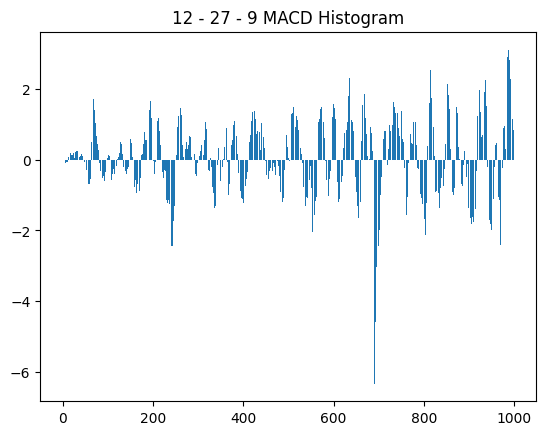

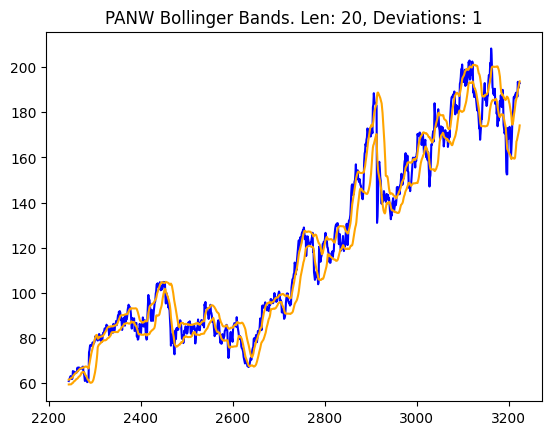

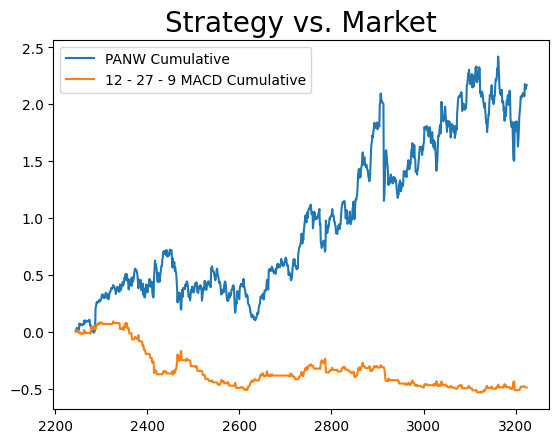

In [26]:
TICKER = 'PANW'
INTERVAL='1d'
BB_LEN = 20
DEVS = 1

# set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'

MFI_LENGTH = 14
MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9

# what subsetion of that data are you interested in
LOOKBACK = 1000

def get_data(ticker=TICKER, lookback=LOOKBACK, interval=INTERVAL):

    # get data at interval you want
    df = yf.download(ticker, interval=interval, period=PERIOD)
    df.columns = df.columns.get_level_values(0)

    # reset the index to make plots prettier
    df = df.reset_index(drop=True)

    # only return the subset of data you are interested in
    return df.iloc[-lookback:, :]

def add_MACD(df, fast=MACD_FAST, slow=MACD_SLOW, span=MACD_SPAN):

    df[f'{fast}_ema'] = df['Close'].ewm(span=fast).mean()
    df[f'{slow}_ema'] = df['Close'].ewm(span=slow).mean()

    # macd line is the difference betweent he fast and slow
    df[f'MACD'] = df[f'{fast}_ema'] - df[f'{slow}_ema']

    # macd signal is a 9-period moving average of this line
    df['Signal'] = df['MACD'].ewm(span=span).mean()

    # MACD histogram is almost always what is used in TA
    df['MACD_hist'] = df['MACD'] - df['Signal']

    # plot the histogram
    plt.bar(x=range(len(df)), height=df['MACD_hist'])
    plt.title(f'{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Histogram')

    return df

def add_MACD_strategy(df):

    df['MACD_Strategy'] = 0
    df['MACD_Strategy'] = np.where(df['MACD_hist'] > 0, 1, -1)
    df['MACD_Strategy'] = df['MACD_Strategy'].shift(1)
    return df

def add_bollinger_bands(df, devs=DEVS, bb_len=BB_LEN):

    # can change to ema (use MACD video/code for reference)
    df['BB_SMA'] = df['Close'].rolling(bb_len).mean()

    # get the standard deviation of the close prices for the period
    df['BB_STD'] = df['Close'].rolling(bb_len).std()

    df['Upper_Band'] = df['BB_SMA'] + (devs * df['BB_STD'])
    df['Lower_Band'] = df['BB_SMA'] - (devs * df['BB_STD'])

    df = df.dropna()

    plt.figure()
    plt.plot(df['Close'], color='blue')
    plt.plot(df['Upper_Band'], color='orange')
    plt.plot(df['Lower_Band'], color='orange')

    plt.title(f'{TICKER} Bollinger Bands. Len: {BB_LEN}, Deviations: {DEVS}');

    return df

def add_BB_strategy(df):
    df['BB_Strategy'] = 0
    df['BB_Strategy'] = np.where(
        df['Close'] > df['Upper_Band'], 1, 
        np.where(df['Close'] < df['Lower_Band'], -1, 0)
        )
    
    df['BB_Strategy'] = df['BB_Strategy'].shift(1)
    
    return df

def add_full_strategy(df):

    df['Full_Strategy'] = df['MACD_Strategy'] + df['BB_Strategy']

    # adjust values for simplicity
    df['Strategy'] = np.where(df['Full_Strategy'] == 2, 1, 
                     np.where(df['Full_Strategy'] == -2, -1, 0))

    return df

def test_strategy(df):

    df['Asset_Returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1 + df['Close'].pct_change() * df['Strategy']).cumprod() -1

    plt.figure()
    plt.plot(df['Asset_Returns'])
    plt.plot(df['Strategy_Returns'])
    plt.legend([f'{TICKER} Cumulative', f'{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Cumulative'])
    plt.title('Strategy vs. Market', size='20')

    return df

def main():
    df = get_data()
    df = add_MACD(df)
    df = add_bollinger_bands(df)
    df = add_MACD_strategy(df)
    df = add_BB_strategy(df)
    df = add_full_strategy(df)
    df = test_strategy(df)

    return df

df = main()
df